## First Part: DMD Parameters

24.848484848484844
diffraction order at blaze angle:  -2.9907928232199668
angle of reflection at blaze angle:  -48.92848484848485


Text(0.5, 0, 'Incident angle $\\alpha$')

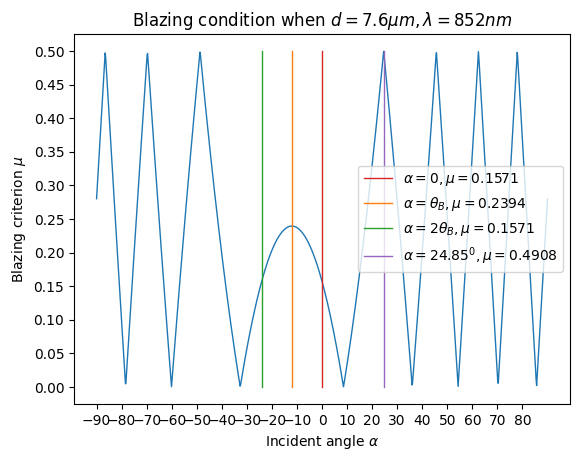

In [2]:
# -*- coding: utf-8 -*-
# Written by Sebastien Popoff, adapted by Shengfu Cheng
# 08/06/2020
import matplotlib.pyplot as plt
import numpy as np

import matplotlib as mpl
from matplotlib import rc

## Parameters of blaze grating
# 400 grooves / mm, so each groove is 1/400 mm = 2.5 microns
d = 10.8/np.sqrt(2) #micromirror pitch
gamma = -12.04/180*np.pi  #micromirror tilt angle relative to flat state

#Use sqrt(2) to calibrate the incident angle and tilt angle 
#the angle of rotation of the mirrors is at 45 degrees compared to the axis of the pixels
#gamma_1D = np.arctan(np.tan(gamma)/np.sqrt(2))
_lambda = 852e-3 #wavelength

## A simple criterion matching the diffraction angle and the reflection angle
_beta = lambda x: 2*gamma-x
m = lambda x: 1.*d/_lambda * (np.sin(x)+np.sin(_beta(x)))

## Test different incident angles
# when m is an integer, we are at a blazing angle with a maximum of energy at the order along the optical axis
# whem m is n+1/2, the enregy is spread over many diffraction orders not aligned with the optical axis
alpha_vec = np.linspace(-np.pi/2,np.pi/2,1000)
alpha_1D_vec = np.arctan(np.tan(alpha_vec)/np.sqrt(2))
criterion = np.abs(np.mod([m(a) for a in alpha_vec],1)-0.5) # minimized at half integer values, which is bad. larger values are better 
# find incident angle
alpha_loc = np.linspace(0,np.pi/3,100)
best_incident_angle = 0
for a in alpha_loc:
    if np.abs(np.mod(m(a),1)-0.5) > np.abs(np.mod(m(best_incident_angle),1)-0.5):
        best_incident_angle = a
print(best_incident_angle*180/np.pi)
print("diffraction order at blaze angle: ", m(best_incident_angle))
print("angle of reflection at blaze angle: ", _beta(best_incident_angle)*180/np.pi)
plt.figure()
plt.plot(alpha_vec*180/np.pi,criterion,linewidth = 1)

plt.plot([0,0],[0.,0.5],color = 'C3',label = r'$\alpha = 0, \mu = %.4f$' \
    % np.abs(np.mod(m(0),1)-0.5), linewidth = 1) #At Normal line of grating surface 

plt.plot([gamma*180/np.pi,gamma*180/np.pi],[0.,0.5],color = 'C1',label = r'$\alpha = \theta_B, \mu = %.4f$' \
     % np.abs(np.mod(m(gamma),1)-0.5),linewidth = 1) #At Normal line of groove surface 

plt.plot([2*gamma*180/np.pi,2*gamma*180/np.pi],[0.,0.5],color = 'C2',label = r'$\alpha = 2\theta_B, \mu = %.4f$' \
    % np.abs(np.mod(m(2*gamma),1)-0.5), linewidth = 1) #2-time angles away from the normal of grating surface

plt.plot([best_incident_angle*180/np.pi,best_incident_angle*180/np.pi],[0.,0.5],color = 'C4',label = r'$\alpha = %.2f^{0}, \mu = %.4f$' \
    % (best_incident_angle*180/np.pi, np.abs(np.mod(m(best_incident_angle),1)-0.5)), linewidth = 1) #blaze angle

plt.xticks(np.arange(-90,90,10))
plt.yticks(np.arange(0,0.55,0.05))
plt.title(r'Blazing condition when $d=%.1f\mu m, \lambda =%g nm$' % (d,1e3*_lambda))
plt.legend(loc='center right')
plt.ylabel(r'Blazing criterion $\mu$')
plt.xlabel(r'Incident angle $\alpha$')


## 2nd Part: Efficiency of blazed grating given an incident angle

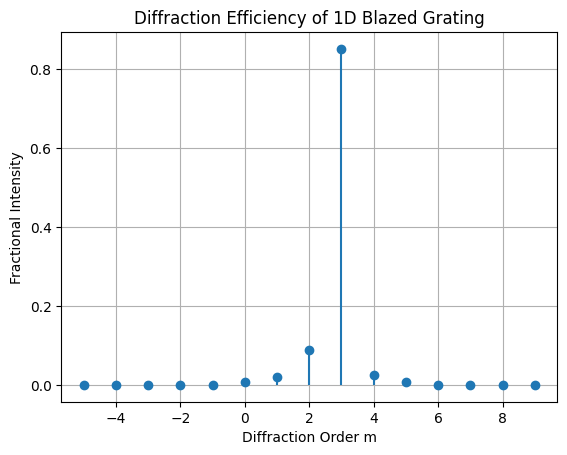

In [9]:
# Parameters
theta_i_deg = 48     # incidence angle in degrees
theta_b_deg = 11.54     # blaze angle in degrees
# Convert angles to radians
theta_i = np.radians(theta_i_deg)
theta_b = np.radians(theta_b_deg)

d = 2.5e-6
_lambda = 852e-9

h = d * np.cos(theta_b)  # effective facet width


# Range of orders to compute
orders = np.arange(-5, 10)
eta = []

for m in orders:
    sin_theta_r = m * _lambda / d - np.sin(theta_i)
    if abs(sin_theta_r) > 1:
        eta.append(0)
    else:
        # Blaze efficiency
        delta = sin_theta_r - np.sin(theta_b)
        arg = np.pi * h / _lambda * delta
        sinc_sq = (np.sinc(arg/np.pi))**2 # divide by pi because sinc is defined as sinc(x) = sin(pi*x)/(pi*x)
        eta.append(sinc_sq)

# Normalize
eta = np.array(eta)
I_m = eta / eta.sum()

# Plot
plt.stem(orders, I_m, basefmt=" ")
plt.xlabel("Diffraction Order m")
plt.ylabel("Fractional Intensity")
plt.title("Diffraction Efficiency of 1D Blazed Grating")
plt.grid(True)
plt.show()


1D simulation of the Fourier plane for blaze grating

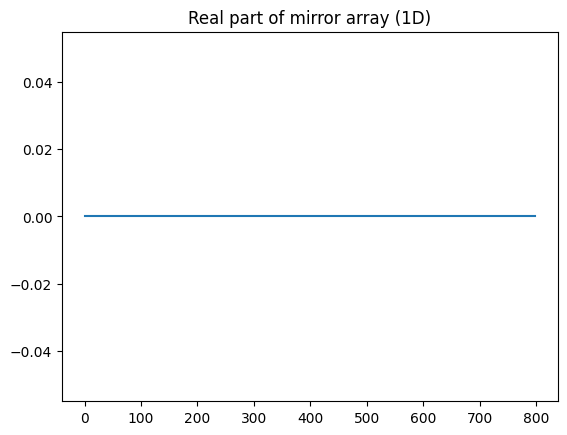

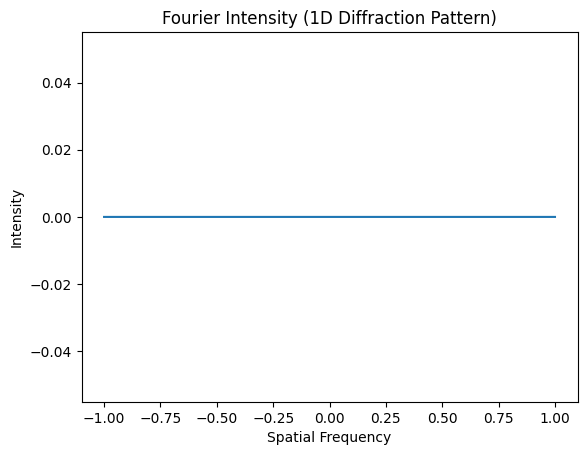

In [11]:

## A full numerical simulation of the Fourier plane for an all-on configuration
alpha = 48/180*np.pi # Incident angle
gamma = 11.54/180*np.pi  # micromirror tilt angle relative to flat state
#alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
beta = -alpha +2*gamma # reflection angle, same side of the normal as the incident angle
#alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
#beta_1D = 2*gamma_1D-alpha_1D#np.arctan(np.tan(beta)/np.sqrt(2))
N = 40 # number of grooves
g = 2.5 # gap between mirrors in micron
res = 20 # pixels per mirror 
Nx = N*res

## Pixelate image function
## Phase slope due to incident and reflection angle
X = np.arange(N)
phi = np.exp((X)*1j*2*np.pi/_lambda*d*(np.sin(alpha)+np.sin(beta))) 

## cell unit
Cell = np.zeros(res)
gpix = int(np.round(g/(2.*d)*res))
Cell[gpix:res-gpix] = 1.
## Mirror image
MI = np.zeros([Nx],dtype='complex')
for i in range(N):
    MI[i*res:(i+1)*res]= phi[i]*Cell
plt.figure()
plt.title("Real part of mirror array (1D)")
plt.plot(np.real(MI))

## In the Fourier plane
coeff = 5
FP_1D = np.fft.fftshift(np.fft.fft(MI,n=coeff*Nx))
xaxis = np.linspace(-1, 1, coeff*Nx)

# plot the fourier transform intensities against angle of reflection
# Calculate angle of reflection for each spatial frequency
theta = np.arcsin(xaxis) * 180 / np.pi  # in degrees

plt.figure()
plt.title("Fourier Intensity (1D Diffraction Pattern)")
plt.plot(xaxis, np.abs(FP_1D))
plt.xlabel("Spatial Frequency")
plt.ylabel("Intensity")

plt.show()



C:\Users\Sneez\AppData\Local\Temp\ipykernel_41224\530380298.py:39: UserWarning: You passed a edgecolor/edgecolors ('red') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(ROIsize//2, ROIsize//2, s=200, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 1.,  marker='x')


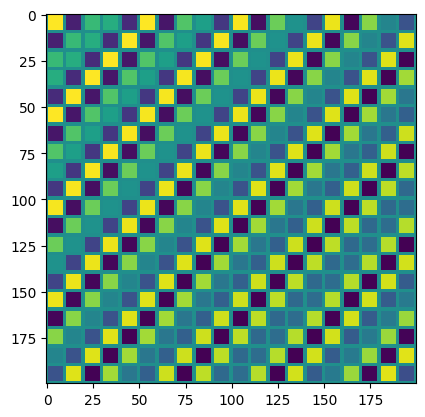

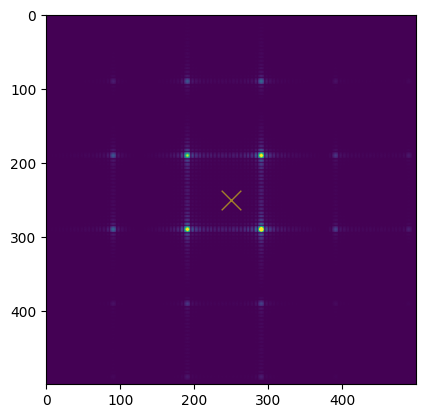

In [4]:

## A full numerical simulation of the Fourier plane for an all-on configuration
# alpha = 24/180*np.pi # Incident angle
alpha = 24
#alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
beta = -alpha +2*gamma # reflection angle, same side of the normal as the incident angle
#alpha_1D = np.arctan(np.tan(alpha)/np.sqrt(2))
#beta_1D = 2*gamma_1D-alpha_1D#np.arctan(np.tan(beta)/np.sqrt(2))
N = 20# number of mirrors in each direction
g = 1 # gap between mirrors in micron
res = 10 # pixels per mirror 
Nx = N*res

## Pixelate image function
f = np.ones([N,N]) # all-on configuration
## Phase slope due to incident and reflection angle
X,Y = np.meshgrid(np.arange(N),np.arange(N))
phi = np.exp((X+Y)*1j*2*np.pi/_lambda*d/np.sqrt(2)*(np.sin(alpha)+np.sin(beta))) 

## cell unit
Cell = np.zeros([res,res])
gpix = int(np.round(g/(2.*d)*res))
Cell[gpix:res-gpix,gpix:res-gpix] = 1.
## Mirror image
MI = np.zeros([Nx,Nx],dtype='complex')
for i in range(N):
    for j in range(N):
        MI[i*res:(i+1)*res,j*res:(j+1)*res]= f[i,j]*phi[i,j]*Cell
plt.figure()
plt.imshow(np.real(MI),interpolation = 'None')

## In the Fourier plane
coeff = 5
FP = np.fft.fftshift(np.fft.fft2(MI,s=[coeff*Nx,coeff*Nx]))
ROIsize = 500
ROI = 1
plt.figure()
plt.imshow((np.abs(FP[coeff*Nx//2-ROIsize//2:coeff*Nx//2+ROIsize//2,coeff*Nx//2-ROIsize//2:coeff*Nx//2+ROIsize//2])),interpolation = 'None')
plt.clim([0,(np.max(np.abs(FP)))/1.5])
plt.scatter(ROIsize//2, ROIsize//2, s=200, edgecolors='red',alpha = 0.5,c='yellow',linewidths= 1.,  marker='x')

plt.show()


Grating angle optimizer

DMD angle of incidence θi,DMD: 10.00 degrees
DMD angle of reflection θr,DMD: 34.00 degrees


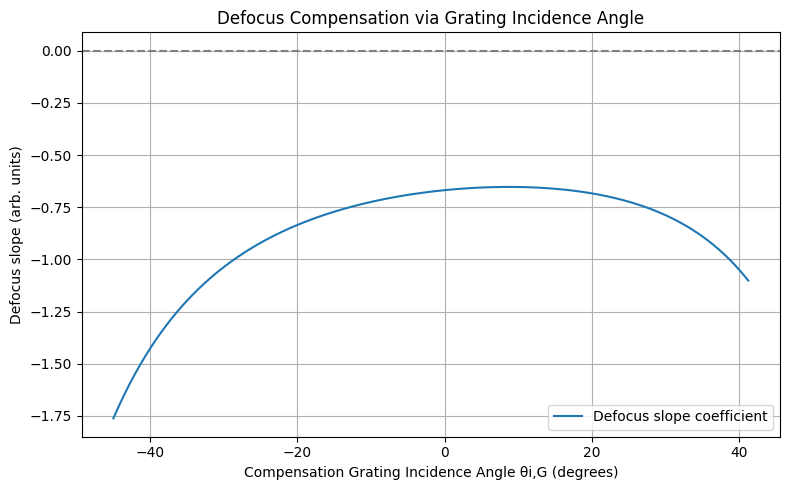

In [20]:

# === USER INPUTS ===
λ = 852e-9               # Wavelength in meters
d_DMD = 10.8/np.sqrt(2) * 1e-6          # DMD pixel pitch in meters
θb_DMD = np.deg2rad(12)  # DMD blaze angle in radians
d_G = 2.5e-6             # Compensation grating pitch in meters
M = 1                    # Telescope magnification (usually 1)
m_DMD = -3                # Diffraction order used for DMD blazing
m_G = 1                  # Diffraction order used on grating
θiG_deg_range = np.linspace(-45, 45, 500)  # Range of grating incidence angles to try

# === CALCULATIONS ===

def blazing_angle_dmd(m):
    arg = -m * λ / (2 * d_DMD * np.sin(θb_DMD))
    if np.abs(arg) > 1:
        return None, None
    θi = np.arccos(arg) - θb_DMD
    θr = np.arccos(arg) + θb_DMD
    return θi, θr

θi_DMD, θr_DMD = blazing_angle_dmd(-m_DMD)

θi_DMD = np.deg2rad(10) # Set a fixed DMD angle of incidence for testing
θr_DMD = θi_DMD + 2*θb_DMD
if θi_DMD is None:
    raise ValueError("Invalid DMD blazing angle. Try a smaller diffraction order m_DMD.")
print(f"DMD angle of incidence θi,DMD: {np.rad2deg(θi_DMD):.2f} degrees")
print(f"DMD angle of reflection θr,DMD: {np.rad2deg(θr_DMD):.2f} degrees")
defocus_slopes = []

for θiG_deg in θiG_deg_range:
    θi_G = np.deg2rad(θiG_deg)
    sin_θr_G = np.sin(θi_G) + m_G * λ / d_G
    if np.abs(sin_θr_G) > 1:
        defocus_slopes.append(np.nan)
        continue
    θr_G = np.arcsin(sin_θr_G)
    β_D = np.cos(θr_DMD) / np.cos(θi_DMD)
    β_G = np.cos(θr_G) / np.cos(θi_G)

    term1 = M * np.sin(θi_DMD) * β_D**2 * β_G**2
    term2 = -M * np.sin(θr_DMD) * β_G**2
    term3 = (np.cos(θr_DMD) / np.cos(θi_G)) * (np.sin(θi_G) * β_G**2 - np.sin(θr_G))
    slope = M * (term1 + term2 + term3)
    defocus_slopes.append(slope)

# === PLOT ===

plt.figure(figsize=(8, 5))
plt.plot(θiG_deg_range, defocus_slopes, label='Defocus slope coefficient')
plt.axhline(0, color='gray', linestyle='--')
plt.xlabel('Compensation Grating Incidence Angle θi,G (degrees)')
plt.ylabel('Defocus slope (arb. units)')
plt.title('Defocus Compensation via Grating Incidence Angle')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
